In [1]:
#..modified by CHUYAN at Nov/05/2021; calculate binned P-E/SST/subsidence/ LTS and LWP/(TWP) array for Model: CESM2; (annual-mean, binned 5X5 degree,
#.. area-mean data,) for pi-Control and abrupt4XCO2 experiment, then use the sensitivity of LWP to CCFs to get a Linear regression model to predict
#.. the LWP and d(LWP)/dGMT.. However, we wants to know why different SST zone will have diff efficiency in producing clouds with Warming..

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd

from scipy import stats
from sklearn import linear_model

from sklearn.metrics import mean_squared_error, r2_score
from read_hs_file import read_var_mod

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm


In [2]:
#..netCDF4 for retrieving variables in 'pi' and 'abr': 

#..abrupt4xCO2
sfc_T_abr       = read_var_mod(modn='CESM2', consort='NCAR', varnm='ts', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]

T_700_alevs_abr,P,lat_abr,lon_abr,times_abr = read_var_mod(modn='CESM2', consort='NCAR', varnm='ta', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=True, time1=[1, 1, 1], time2=[150, 12, 31])
T_700_abr = T_700_alevs_abr[:, 3,:,:]   #..700 hPa levels

sfc_P_abr       = read_var_mod(modn='CESM2', consort='NCAR', varnm='ps', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]   

sub_abr         = read_var_mod(modn='CESM2', consort='NCAR', varnm='wap', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=True, time1=[1, 1, 1], time2=[150, 12, 31])[0][:, 5,:,:] 
#..500mb downward motions

clivi_abr       = read_var_mod(modn='CESM2', consort='NCAR', varnm='clivi', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]
clwvi_abr       = read_var_mod(modn='CESM2', consort='NCAR', varnm='clwvi', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]
tas_abr         = read_var_mod(modn='CESM2', consort='NCAR', varnm='tas', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]

P_abr           = read_var_mod(modn='CESM2', consort='NCAR', varnm='pr', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]

E_abr           = read_var_mod(modn='CESM2', consort='NCAR', varnm='evspsbl', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]
print(sfc_T_abr.shape)

prw_abr         = read_var_mod(modn='CESM2', consort='NCAR', varnm='prw', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[150, 12, 31])[0]
#..1800 months =150 yrs for CESM2:abrupt experiemnt



#..Total Water Path
#fn_wvp_abr  = xr.open_dataset('/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/prw/gn/v20190828/prw_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc')

#prw_abr = np.array(fn_wvp_abr.variables['prw'])   #..Water Vapor Path , kg m-2

#fn_wvp_pi   = xr.open_dataset('/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/prw/gn/files/d20190320/prw_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc')
#prw_pi  = np.array(fn_wvp_pi.variables['prw'])


#..pi-Control
sfc_T       = read_var_mod(modn='CESM2', consort='NCAR', varnm='ts', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]

T_700_alevs,times_pi = read_var_mod(modn='CESM2', consort='NCAR', varnm='ta', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=True, time1=[1, 1, 1], time2=[99, 12, 31])[0],[4]
T_700       = T_700_alevs[:, 3,:,:]

sfc_P       = read_var_mod(modn='CESM2', consort='NCAR', varnm='ps', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]   
#..sea surface Pressure, Units in Pa

sub         = read_var_mod(modn='CESM2', consort='NCAR', varnm='wap', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=True, time1=[1, 1, 1], time2=[99, 12, 31])[0][:, 5,:,:] 
#..500mb downward mot0001

clivi       = read_var_mod(modn='CESM2', consort='NCAR', varnm='clivi', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]
#..ICE WATER PATH, Units in kg m^-2
clwvi       = read_var_mod(modn='CESM2', consort='NCAR', varnm='clwvi', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]
tas         = read_var_mod(modn='CESM2', consort='NCAR', varnm='tas', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]
#..2-m air Temperature, for 'gmt'

P           = read_var_mod(modn='CESM2', consort='NCAR', varnm='pr', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]
#..Precipitation, Units in kg m^-2 s^-1 = mm *s^-1
E           = read_var_mod(modn='CESM2', consort='NCAR', varnm='evspsbl', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]
#..Evaporations, Units also in kg m^-2 s^-1 = mm *s^-1

print(sfc_T.shape)


prw_pi      =read_var_mod(modn='CESM2', consort='NCAR', varnm='prw', cmip='cmip6', exper='piControl', ensmem='r1i1p1f1', typevar='Amon', gg='gn', read_p=False, time1=[1, 1, 1], time2=[99, 12, 31])[0]
#..6000 months =99 yrs for CESM2 piControl experiemnt


['/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/files/d20190828/', '/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/files/d20190425/', '/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/files/d20190927/']
/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/files/d20190828//*ts**_**nc*
/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/files/d20190828/ts_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc


/glade/work/chuyan/Research/linear_regression_CCFs_Clouds_metrics/read_hs_file.py:123: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  data = f.variables[varnm][ind]


(1800, 192, 288)
['/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ta/gn/files/d20190828/', '/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ta/gn/files/d20190425/', '/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ta/gn/files/d20190927/']
/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ta/gn/files/d20190828//*ta**_**nc*
/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ta/gn/files/d20190828/ta_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc
(1800, 19, 192, 288)
['/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/files/d20190828/', '/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/files/d20190425/', '/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/files/d20190927/']
/glade/collections/cmip//CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/files/d20190828//*p

In [3]:
#..choose lat 40 -85 °S as the Southern-Ocean Regions

lons        = lon_abr
lats        = lat_abr[:]

levels      = np.array(P)
times       = times_abr
#print(lats, lons)

lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))
print(latsi0, latsi1)


53 5


In [4]:
#..abrupt4xCO2
Precip_abr =  np.array(P_abr) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip_abr))   #.. IPSL/abr2.80..  CNRM ESM2 1/abr 2.69.. CESM2/abr 2.74..
Eva_abr    =  np.array(E_abr) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva_abr))         #.. IPSL/abr2.50..  CNRM ESM2 1/abr 2.43.. CESM2/abr 2.43..
print(Eva_abr.shape)

print(np.nanmean(tas_abr))

#..pi-Control
Precip =  np.array(P) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip))   #.. IPSL/piC 2.43..CNRM/piC 2.40.. CESM2/PIc 2.39
Eva    =  np.array(E) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva))   #.. IPSL/piC  2.21..CNRM/piC 2.20.. CESM2/PIc 2.17..
print(Eva.shape)


print(np.nanmean(tas))

2.7373567
2.4275835
(1800, 192, 288)
284.75894
2.3886583
2.1690202
(1188, 192, 288)
277.30536


In [5]:
#..abrupt4xCO2 Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP_abr  = np.array(clwvi_abr) - np.array(clivi_abr)   #..units in kg m^-2

gmt_abr  = np.array(tas_abr)

SST_abr  = np.array(sfc_T_abr)

MC_abr  = Precip_abr - Eva_abr   #..Moisture Convergence calculated from abrupt4xCO2's P - E, Units in mm day^-1

Twp_abr  = np.array(clwvi_abr)
Iwp_abr  = np.array(clivi_abr)


#..pi-Control Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP  = np.array(clwvi) - np.array(clivi)   #..units in kg m^-2

gmt  = np.array(tas)

SST  = np.array(sfc_T)

MC  = Precip - Eva   #..Moisture Convergence calculated from pi-Control's P - E, Units in mm day^-1

Twp  = np.array(clwvi)
Iwp  = np.array(clivi)

In [6]:
#..abrupt4xCO2 Lower Tropospheric Stability
k  = 0.286
theta_700_abr  = np.array(T_700_abr)* (100000./70000.)**k

#print(theta_700_abr)

theta_skin_abr = np.array(sfc_T_abr)* (100000./np.array(sfc_P_abr))**k
LTS_m_abr  = theta_700_abr - theta_skin_abr

#..Subtract the outliers in T_700 and LTS_m, 'nan' comes from
LTS_e_abr  = np.ma.masked_where(theta_700_abr >= 500, LTS_m_abr)
#print(LTS_e_abr)

#..Subsidence, units in Pa s^-1 at 500 hPa:
Subsidence_abr =  np.array(sub_abr)


#..pi-Control Lower Tropospheric Stability

theta_700  = np.array(T_700)* (100000./70000.)**k

#print(theta_700)

theta_skin = np.array(sfc_T)* (100000./np.array(sfc_P))**k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m, 'nan' comes from
LTS_e  = np.ma.masked_where(theta_700 >= 500, LTS_m)
#print(LTS_e, LTS_m)

#..Subsidence, units in Pa s^-1 at 500 hPa:
Subsidence =  np.array(sub)


In [7]:
indf= np.isnan(LTS_e_abr)==True
indf_false = np.nonzero(indf ==True)

print(indf_false)
print(np.array(indf_false).shape)

print(LTS_e_abr[11,7,14],LTS_m_abr[11,7,14], T_700_abr[11,7,14])



(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(3, 0)
11.298676 11.298676 251.50562


In [8]:
#..Convert variables becoming Annual-mean, Southern-Ocean region arrays

#..abrupt4xCO2
Tg_abr  = np.zeros((150,192,288))   #..Surface air Temperature, GMT, shapein (300,143,144)!!
LWP_yr_abr  = np.zeros((150,48,288))

p_e_yr_abr  = np.zeros((150,48,288))
SST_yr_abr  = np.zeros((150,48,288))
SUB_yr_abr  = np.zeros((150,48,288))
LTS_yr_abr  = np.zeros((150,48,288))

TWP_yr_abr  = np.zeros((150,48,288))
IWP_yr_abr  = np.zeros((150,48,288))
PRW_yr_abr  = np.zeros((150,48,288))

#..annual mean data of LWP, Tg and CCFs

for i in range(0, 150):     #..shape in 3yr !!
    Tg_abr[i,:,:]     = np.nanmean(gmt_abr[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr_abr[i,:,:]  = np.nanmean(LWP_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr_abr[i,:,:] = np.nanmean(MC_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr_abr[i,:,:]    = np.nanmean(SST_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr_abr[i,:,:]    = np.nanmean(LTS_e_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr_abr[i,:,:]    = np.nanmean(Subsidence_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    TWP_yr_abr[i,:,:]  = np.nanmean(Twp_abr[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    IWP_yr_abr[i,:,:]  = np.nanmean(Iwp_abr[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    PRW_yr_abr[i,:,:]  = np.nanmean(prw_abr[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    
print(Tg_abr.shape, PRW_yr_abr.shape)   #..shape in (150, 192, 288) or (150, 48, 288)


#..pi-Control
Tg  = np.zeros((99,192,288))   #..Surface air Temperature, GMT; need to be attention for the dimensions!!
LWP_yr  = np.zeros((99,48,288))

p_e_yr  = np.zeros((99,48,288))
SST_yr  = np.zeros((99,48,288))
SUB_yr  = np.zeros((99,48,288))
LTS_yr  = np.zeros((99,48,288))
TWP_yr  = np.zeros((99,48,288))
IWP_yr  = np.zeros((99,48,288))
PRW_yr  = np.zeros((99,48,288))
#..annual mean data of LWP, Tg and CCFs

for i in range(0, 99):
    Tg[i,:,:]     = np.nanmean(gmt[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr[i,:,:]  = np.nanmean(LWP[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr[i,:,:] = np.nanmean(MC[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr[i,:,:]  = np.nanmean(SST[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr[i,:,:]  = np.nanmean(LTS_e[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr[i,:,:]  = np.nanmean(Subsidence[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    TWP_yr[i,:,:]  = np.nanmean(Twp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    IWP_yr[i,:,:]  = np.nanmean(Iwp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    PRW_yr[i,:,:]  = np.nanmean(prw_pi[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)

print(Tg.shape, p_e_yr.shape)
#print(lat_array.shape,lon_array)


(150, 192, 288) (150, 48, 288)
(99, 192, 288) (99, 48, 288)


In [9]:
p=np.nanmean(LTS_e_abr[0:12,latsi1:latsi0,:], axis=0)
indg  = np.isnan(LTS_yr) == True
indg_false  = np.nonzero(indg == True)


print(LTS_yr[0,4,24], p.shape, p[4,24])
print(indg_false)
print(np.array(indg_false).shape)

27.389230728149414 (48, 288) 27.565384
(array([ 0,  0,  0, ..., 98, 98, 98]), array([ 0,  0,  0, ..., 16, 16, 16]), array([148, 149, 150, ..., 220, 221, 222]))
(3, 148049)


In [10]:
from binned_cyFunctions5 import *

In [11]:
from area_mean import *

#..set are-mean range and define function

x_range  = np.arange(0., 364, 5.)   #..number:73
s_range  = np.arange(-90., 90, 5.) + 2.5 #..(36)

y_range  = np.arange(-85, -35., 5.) +2.5

In [12]:
#..abrupt4X Calculate 5*5 binned array for variables (LWP, CCFs) in Sounthern Ocean regions:

lat_array  = lats[latsi1:latsi0]
lon_array  = lons
lat_array1 =  lats


Tg_yr_bin_abr  = binned_cyGlobal5(Tg_abr, lat_array1, lon_array)
SST_yr_bin_abr  = binned_cySouthOcean5(SST_yr_abr, lat_array, lon_array)

p_e_yr_bin_abr  = binned_cySouthOcean5(p_e_yr_abr, lat_array, lon_array)
LWP_yr_bin_abr  = binned_cySouthOcean5(LWP_yr_abr, lat_array, lon_array)   #..shape in (150,10,73)

LTS_yr_bin_abr  = binned_cySouthOcean5(LTS_yr_abr, lat_array, lon_array)
SUB_yr_bin_abr  = binned_cySouthOcean5(SUB_yr_abr, lat_array, lon_array)
TWP_yr_bin_abr  = binned_cySouthOcean5(TWP_yr_abr, lat_array, lon_array)
IWP_yr_bin_abr  = binned_cySouthOcean5(IWP_yr_abr, lat_array, lon_array)
print(Tg_yr_bin_abr.shape)   #..(150, 36, 73)

PRW_yr_bin_abr  = binned_cySouthOcean5(PRW_yr_abr, lat_array, lon_array)
print(PRW_yr_bin_abr.shape)

#..piC Calculate 5*5 binned array for variables(LWP, ccfs) in Sounthern Ocean region:

gmt_yr_bin  = binned_cyGlobal5(Tg, lat_array1, lon_array)
SST_yr_bin  = binned_cySouthOcean5(SST_yr, lat_array, lon_array)

p_e_yr_bin  = binned_cySouthOcean5(p_e_yr, lat_array, lon_array)
LWP_yr_bin  = binned_cySouthOcean5(LWP_yr, lat_array, lon_array)   #..shape in (99,10,73)

LTS_yr_bin  = binned_cySouthOcean5(LTS_yr, lat_array, lon_array)
SUB_yr_bin  = binned_cySouthOcean5(SUB_yr, lat_array, lon_array)
TWP_yr_bin  = binned_cySouthOcean5(TWP_yr, lat_array, lon_array)
IWP_yr_bin  = binned_cySouthOcean5(IWP_yr, lat_array, lon_array)

PRW_yr_bin  = binned_cySouthOcean5(PRW_yr, lat_array, lon_array)
print(SUB_yr_bin.shape)   #..(99, 10, 73)



(150, 36, 73)
(150, 10, 73)
(99, 10, 73)


In [13]:
#..abrupt4X Calculate 5*5 binned array for Monthly variables (LWP, CCFs) in Sounthern Ocean regions:

lat_array  = lats[latsi1:latsi0]
lon_array  = lons
lat_array1 =  lats


Tg_mon_bin_abr  = binned_cyGlobal5(gmt_abr, lat_array1, lon_array)
SST_mon_bin_abr  = binned_cySouthOcean5(SST_abr[:, latsi1:latsi0,:], lat_array, lon_array)

p_e_mon_bin_abr  = binned_cySouthOcean5(MC_abr[:, latsi1:latsi0,:], lat_array, lon_array)
LWP_mon_bin_abr  = binned_cySouthOcean5(LWP_abr[:, latsi1:latsi0,:], lat_array, lon_array)   #..shape in (1800,10,73)

LTS_mon_bin_abr  = binned_cySouthOcean5(LTS_e_abr[:, latsi1:latsi0,:], lat_array, lon_array)
SUB_mon_bin_abr  = binned_cySouthOcean5(Subsidence_abr[:, latsi1:latsi0,:], lat_array, lon_array)
TWP_mon_bin_abr  = binned_cySouthOcean5(Twp_abr[:, latsi1:latsi0,:], lat_array, lon_array)
IWP_mon_bin_abr  = binned_cySouthOcean5(Iwp_abr[:, latsi1:latsi0,:], lat_array, lon_array)
PRW_mon_bin_abr  = binned_cySouthOcean5(prw_abr[:, latsi1:latsi0,:], lat_array, lon_array)

print(PRW_mon_bin_abr.shape)   #..(1800,10,73)

#..piC Calculate 5*5 binned array for MONTHLY variables(LWP, ccfs) in Sounthern Ocean region:

gmt_mon_bin  = binned_cyGlobal5(gmt, lat_array1, lon_array)
SST_mon_bin  = binned_cySouthOcean5(SST[:, latsi1:latsi0,:], lat_array, lon_array)

p_e_mon_bin  = binned_cySouthOcean5(MC[:, latsi1:latsi0,:], lat_array, lon_array)
LWP_mon_bin  = binned_cySouthOcean5(LWP[:, latsi1:latsi0,:], lat_array, lon_array)

LTS_mon_bin  = binned_cySouthOcean5(LTS_e[:, latsi1:latsi0,:], lat_array, lon_array)
SUB_mon_bin  = binned_cySouthOcean5(Subsidence[:, latsi1:latsi0,:], lat_array, lon_array)
TWP_mon_bin  = binned_cySouthOcean5(Twp[:, latsi1:latsi0,:], lat_array, lon_array)
IWP_mon_bin  = binned_cySouthOcean5(Iwp[:, latsi1:latsi0,:], lat_array, lon_array)
PRW_mon_bin  = binned_cySouthOcean5(prw_pi[:, latsi1:latsi0,:], lat_array, lon_array)

print(PRW_mon_bin.shape)  #..shape in (1188,10,73)

(1800, 10, 73)
(1188, 10, 73)


In [14]:

#..piC Ravel binned array / Standardized data ARRAY:

TR_sst     = 270.


LWP_predi  = LWP_yr_bin.flatten()
#LWP_predi =  (LWP_predi - np.mean(LWP_predi) )/np.std(LWP_predi)

SST_predi  = SST_yr_bin.flatten()
#SST_predi =  (SST_predi - np.mean(SST_predi)) /np.std(SST_predi)

p_e_predi =  p_e_yr_bin.flatten()
#p_e_predi =  (p_e_predi - np.mean(p_e_predi)) /np.std(p_e_predi)

LTS_predi  = LTS_yr_bin.flatten()
#LTS_predi =  (LTS_predi - np.nanmean(LTS_predi)) /np.nanstd(LTS_predi)

SUB_predi  = SUB_yr_bin.flatten()
#SUB_predi  = (SUB_predi - np.mean(SUB_predi)) /np.std(SUB_predi)

TWP_predi  = TWP_yr_bin.flatten()

PRW_predi  = PRW_yr_bin.flatten()

print(np.min(LTS_predi), np.max(LTS_predi), LTS_predi.shape)

#..Subtract 'nan' in data, 72270 -> 66598points(5672)

ind1 = np.isnan(LTS_predi) ==False 
ind_true = np.nonzero(ind1 ==True)

print(np.array(ind_true).shape)
ind_false = np.nonzero(ind1==False)

#..without LTS: 'nan' points' number : 66598 

ind_sst_le  = np.nonzero(SST_predi >=TR_sst)
print(ind_sst_le)
ind2  = np.intersect1d(ind_true, ind_sst_le)
print(ind2.shape)   #..31258 points

ind_sst_st  = np.nonzero(SST_predi < TR_sst)
#print(np.array(ind_sst_st).shape)
ind3  = np.intersect1d(ind_true, ind_sst_st)
print(ind3.shape)   #..35340 points


#..sign LWP single array's value
YB =  np.full((72270), 0.0)   #..LWP with no LTS 

YB[ind_false] =  LWP_predi[ind_false]

print(YB, ind_false)
print(YB.shape)


nan nan (72270,)
(1, 66527)
(array([  304,   305,   306, ..., 72267, 72268, 72269]),)
(34614,)
(31913,)
[0. 0. 0. ... 0. 0. 0.] (array([   40,    41,    42, ..., 71747, 71748, 71749]),)
(72270,)


In [15]:
#..piC  Multiple linear regreesion of Liquid Water Path(lwp) to CCFs :

#..Remove abnormal and missing_values, train model with TR sst>=270K

X  = np.array([SST_predi[ind2], p_e_predi[ind2], LTS_predi[ind2], SUB_predi[ind2]])

regr1 = linear_model.LinearRegression()
result1 = regr1.fit(X.T, LWP_predi[ind2])   #..LWP

print(result1.coef_)
print(result1.intercept_)

#..for test
a = np.load('sensitivity_4ccfs_ipsl270.npy')
b = np.load('intercept1_ipsl270.npy')
#print(a)
#print(b)

#..Remove abnormal and missing values , train model with TR sst <270.K
XX = np.array([SST_predi[ind3], p_e_predi[ind3], LTS_predi[ind3], SUB_predi[ind3]])

regr2=linear_model.LinearRegression()
result2 = regr2.fit(XX.T, LWP_predi[ind3])   #..LWP


print(result2.coef_)
print(result2.intercept_)

#..Save them...

aeffi  = result1.coef_
aint   = result1.intercept_

beffi  = result2.coef_
bint   = result2.intercept_

[-0.0021316   0.00955052  0.00199909  0.12543413]
0.6879490824481805
[ 0.00250681  0.01176631 -0.00115052  0.22802177]
-0.5710825478547071


In [16]:
print(XX.shape)
print(X.shape)

sstlelwp_predi = np.dot(aeffi.reshape(1, -1),  X)  + aint
sstltlwp_predi = np.dot(beffi.reshape(1, -1), XX)  + bint   #..less than Threshold SST

#print(LWP_predi[ind3])
#print( sstltlwp_predi)

MSE =  mean_squared_error(LWP_predi[ind2].reshape(-1,1), sstlelwp_predi.reshape(-1,1))
print(MSE, np.sqrt(MSE))

R_2  = r2_score(LWP_predi[ind3].reshape(-1, 1), sstltlwp_predi.reshape(-1, 1))
print(R_2)


print( np.mean(LWP_predi[ind2]), np.mean(sstlelwp_predi))
print( np.mean(LWP_predi[ind3]), np.mean(sstltlwp_predi))

(4, 31913)
(4, 34614)
0.0005001113067724801 0.022363168531594087
0.9288243547661907
0.12804720916103537 0.1280472091610354
0.048151571700030156 0.04815157170003024


In [17]:
#..abrupt4X  Calculate the 300* 10* 73 points metric for 'p-e'/other CCFs and LWP and GMT:
#..ravel binned arrays

LWP_bin_pred_abr  = LWP_yr_bin_abr.flatten()   #..shape in 150* 10* 73 =  109500 values

SST_bin_pred_abr  = SST_yr_bin_abr.flatten()
p_e_bin_pred_abr  = p_e_yr_bin_abr.flatten()
LTS_bin_pred_abr  = LTS_yr_bin_abr.flatten()
SUB_bin_pred_abr  = SUB_yr_bin_abr.flatten()

TWP_bin_pred_abr  = TWP_yr_bin_abr.flatten()
IWP_bin_pred_abr  = IWP_yr_bin_abr.flatten()
PRW_bin_pred_abr  = PRW_yr_bin_abr.flatten()

#print(p_e_bin_pred_abr.shape)   #..Tg:(150, 36, 73 ); LWP&CCFs:(150, 10, 73)= 109500 points


#..Use 'np.repeat' and 'np.tile' to reproduce the GMT Array:
GMT_abr  = area_mean(Tg_yr_bin_abr, s_range, x_range)   #..ALL in shape : (500)
gmt_bin_pred_abr  = GMT_abr.repeat(730)
#print(gmt_bin_pred_abr)
#print(GMT_abr)

#..Subtract 'nan' in data, 109500 -> 101428points


ind1_abr =  np.isnan(LTS_bin_pred_abr)==False
ind_true_abr =  np.nonzero(ind1_abr ==True )   #..Sign the the indexing of 'Non-NaN' in LTS_yr_bin
print(np.array(ind_true_abr).shape, LTS_bin_pred_abr[ind_true_abr].shape)

ind_false_abr =  np.nonzero(ind1_abr ==False)   #..Sign the the indexing of 'NaN'
#LTS_yr_bin_abr[ind_false_abr] = 0.0
print(ind1_abr.shape)


#..Subtract data with Skew Temperature larger than 240K, 206114 ->240:190116/ 250:173001points//260:155890 points//270: 134074 points
#..273.15K: 124477 points/ 280K: 73879 points

ind_sst_le_abr  = np.nonzero(SST_bin_pred_abr >= TR_sst)

ind2_abr  = np.intersect1d(ind_true_abr, ind_sst_le_abr)
print(ind2_abr.shape)   #..67194 points


ind_sst_st_abr  = np.nonzero(SST_bin_pred_abr < TR_sst)
ind3_abr =  np.intersect1d(ind_true_abr, ind_sst_st_abr)
print(ind3_abr.shape)  #..34234 points

#..sign values for LWP_abr single array
YB_abr   =  np.full((109500), 0.0)#LWP_bin_pred_abr
#print(YB_abr.shape, YB_abr)

print(ind_false_abr)

YB_abr[ind_false_abr] = LWP_bin_pred_abr[ind_false_abr]

print(LWP_bin_pred_abr)

(1, 101228) (101228,)
(109500,)
(67261,)
(33967,)
(array([    41,     42,     43, ..., 108977, 108978, 108979]),)
[0.01421731 0.01442661 0.01373119 ... 0.08251523 0.05727658 0.04500965]


In [18]:
#..do the regression
#..model1: .le. >= TR_sst
dXx_predi  = np.array(SST_bin_pred_abr[ind2_abr]*aeffi[0] + p_e_bin_pred_abr[ind2_abr]*aeffi[1] + LTS_bin_pred_abr[ind2_abr]*aeffi[2] +SUB_bin_pred_abr[ind2_abr]*aeffi[3])
dXx_predi  = dXx_predi + aint
#print(dXx_predi, dXx_predi.shape)

#..model2: .lt. <  TR_sst
Dx0_predi  = np.array(SST_bin_pred_abr[ind3_abr]*beffi[0] + p_e_bin_pred_abr[ind3_abr]*beffi[1] + LTS_bin_pred_abr[ind3_abr]*beffi[2] +SUB_bin_pred_abr[ind3_abr]*beffi[3])
#dXx_predi_area_yr =  area_mean(dXx_predi, y_range, x_range)

Dx0_predi  =Dx0_predi + bint
#print(Dx0_predi, Dx0_predi.shape)


#..put them in LWP_predi_bin_abr in (1, 219000)
YB_abr[ind2_abr]  = dXx_predi
YB_abr[ind3_abr]  = Dx0_predi
print(YB_abr)
LWP_predi_bin_abr   =  np.array(YB_abr).reshape(150, 10, 73)
print(LWP_bin_pred_abr)

#..Also put pi-C test-pred data in LWP_predi_bin_pi
dXx_predi_pi  = np.array(SST_predi[ind2]*aeffi[0] + p_e_predi[ind2]*aeffi[1] + LTS_predi[ind2]*aeffi[2] + SUB_predi[ind2]*aeffi[3])
dXx_predi_pi  = dXx_predi_pi + aint

Dx0_predi_pi  =  np.array(SST_predi[ind3]*beffi[0] + p_e_predi[ind3]*beffi[1] + LTS_predi[ind3]*beffi[2] + SUB_predi[ind3]*beffi[3])
Dx0_predi_pi  = Dx0_predi_pi + bint


YB[ind2]  = dXx_predi_pi
YB[ind3]  = Dx0_predi_pi
#print(YB)

LWP_predi_bin_pi   =  np.array(YB).reshape(99, 10, 73)   #..LWP

#..Examine model result


MSE_abr =  mean_squared_error(YB_abr.reshape(-1,1), LWP_bin_pred_abr.reshape(-1,1))
R_2_abr  = r2_score(LWP_bin_pred_abr.reshape(-1, 1), YB_abr.reshape(-1, 1))
print(MSE_abr, np.sqrt(MSE_abr), ' ', R_2_abr)


[0.02064128 0.01675976 0.0164735  ... 0.11252202 0.0987897  0.08090397]
[0.01421731 0.01442661 0.01373119 ... 0.08251523 0.05727658 0.04500965]
0.00048458570475022866 0.022013307446865603   0.8498739260015931


In [19]:

#..abrupt4XCO2     linear regreesion of Cloud Controlling Factors (CCFs) to GMT:

regr3 = linear_model.LinearRegression()
re_LWP = regr3.fit(gmt_bin_pred_abr[ind_true_abr].reshape(-1,1), LWP_bin_pred_abr[ind_true_abr])

print(re_LWP.coef_)
print(re_LWP.intercept_)


regr4 = linear_model.LinearRegression()
regr5 = linear_model.LinearRegression()
regr6 = linear_model.LinearRegression()

regr7 = linear_model.LinearRegression()

re_SST = regr4.fit(gmt_bin_pred_abr[ind_true_abr].reshape(-1,1), SST_bin_pred_abr[ind_true_abr])
re_p_e = regr5.fit(gmt_bin_pred_abr[ind_true_abr].reshape(-1,1), p_e_bin_pred_abr[ind_true_abr])
re_LTS = regr6.fit(gmt_bin_pred_abr[ind_true_abr].reshape(-1,1), LTS_bin_pred_abr[ind_true_abr])

re_SUB = regr7.fit(gmt_bin_pred_abr[ind_true_abr].reshape(-1,1), SUB_bin_pred_abr[ind_true_abr])
print(re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_ )

dX_dTg  = [re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_]

#..[ind2_abr]!!

[0.00185448]
-0.43715048634201203
[1.47709206] [0.06698874] [0.02818774] [0.00010787]


In [20]:
#..abrupt4XCO2: - do area mean
#need auto: Watch out the year
LWP_area_yr  = area_mean(LWP_yr_bin_abr, y_range, x_range)
SST_area_yr  = area_mean(SST_yr_bin_abr, y_range, x_range)
p_e_area_yr  = area_mean(p_e_yr_bin_abr, y_range, x_range)
LTS_area_yr  = area_mean(LTS_yr_bin_abr, y_range, x_range)
SUB_area_yr  = area_mean(SUB_yr_bin_abr, y_range, x_range)

IWP_area_yr  = area_mean(IWP_yr_bin_abr, y_range, x_range)
TWP_area_yr  = area_mean(TWP_yr_bin_abr, y_range, x_range)


LWP_pre_yr   = area_mean(LWP_predi_bin_abr, y_range, x_range)

#..pi-Control  do area mean
LWP_area_yr_pi  = area_mean(LWP_yr_bin, y_range, x_range)
LWP_pre_yr_pi   = area_mean(LWP_predi_bin_pi, y_range, x_range)

GMT_pi  = area_mean(gmt_yr_bin, s_range, x_range)


Yrs  =  np.arange(249)
#print(Yrs)

GMT  = np.full((249), 0.000)
GMT[0:99]  = GMT_pi
GMT[99:]   = GMT_abr


LWP_pre  = np.full((249), 0.0)
LWP_area_yr_whole  = np.full((249), 0.0)

LWP_pre[0:99]  = LWP_pre_yr_pi
LWP_pre[99:]  = LWP_pre_yr

LWP_area_yr_whole[0:99] = LWP_area_yr_pi
LWP_area_yr_whole[99:]  = LWP_area_yr



print(LTS_area_yr.shape)

print(LWP_area_yr_whole, ' ', LWP_pre)

#print(GMT)

(150,)
[0.10543216 0.10372172 0.1053949  0.10095469 0.10205278 0.10042966
 0.10150456 0.10208736 0.10429054 0.1039645  0.10454368 0.10256321
 0.10281241 0.10297811 0.10388622 0.10097838 0.10098005 0.10264097
 0.10456879 0.10200551 0.10333631 0.10075851 0.10247476 0.10158788
 0.10202351 0.10292737 0.10392376 0.10319694 0.10221845 0.10455174
 0.10049687 0.1040201  0.10320334 0.1032924  0.10209995 0.10082917
 0.10189762 0.10104767 0.10105522 0.09904466 0.10495299 0.10387945
 0.10195954 0.1040753  0.10102765 0.09995486 0.10029974 0.1037428
 0.10502122 0.10404542 0.10292208 0.10221238 0.10178677 0.10324613
 0.10152954 0.10389318 0.10266879 0.10269946 0.10291379 0.10131938
 0.10449081 0.1034927  0.10194518 0.10331029 0.10337279 0.10310812
 0.10472828 0.10147765 0.10219927 0.10349129 0.10724247 0.10479776
 0.10361109 0.10080477 0.10475441 0.10462899 0.10369247 0.10198527
 0.10234272 0.10201863 0.10212021 0.10188821 0.10408873 0.10290452
 0.10175089 0.10026672 0.1024175  0.10295179 0.10173322 

(249,)


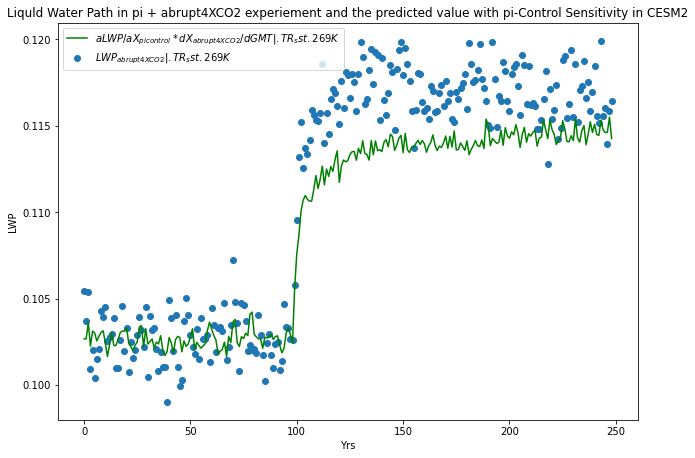

In [28]:
#..abrupt+piC Plot:



fig2  = plt.figure(figsize = (10.4, 7.3))
ax2  = plt.axes()

plt.scatter(Yrs, LWP_area_yr_whole, label='$LWP_{abrupt4XCO2} |.TR_sst.269K$')

print(np.array(Yrs).shape)

plt.plot(Yrs, LWP_pre, "g", label='$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}|.TR_sst.269K$')
#plt.ylim((0.105, 0.121))
273.15

plt.xlabel('Yrs')
plt.ylabel('LWP')
plt.title("Liquld Water Path in pi + abrupt4XCO2 experiement and the predicted value with pi-Control Sensitivity in CESM2")

plt.legend(loc='upper left')

#plt.savefig("Linear_Regression_CESM2_abrupt_bin model_ sixth Merge Regresion269K_ overyears.png")




In [24]:
#..abrupt+piC Plot (real-mean):

'''

fig3  = plt.figure(figsize = (10.4, 7.3))
ax3  = plt.axes()

plt.scatter(GMT, LWP_meanarea_yr_whole, label='$LWP_{abrupt4XCO2} |.TR_sst.270.0K$')

print(np.array(Yrs).shape)

plt.plot(GMT, LWP_meanpre, "g", label='$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}|.TR_sst.270.0K$')


plt.xlabel('GMT')
plt.ylabel('LWP')
plt.title("Real-Mean: Liquid Water Path in pi+ abrupt4XCO2 experiement with the predicted value in IPSL-CM6A-LR")  #..!!


plt.legend()

#plt.savefig("Linear_Regression_IPSLabrupt_bin model_ fifthth Merge Regresion270K.png")
'''



'\n\nfig3  = plt.figure(figsize = (10.4, 7.3))\nax3  = plt.axes()\n\nplt.scatter(GMT, LWP_meanarea_yr_whole, label=\'$LWP_{abrupt4XCO2} |.TR_sst.270.0K$\')\n\nprint(np.array(Yrs).shape)\n\nplt.plot(GMT, LWP_meanpre, "g", label=\'$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}|.TR_sst.270.0K$\')\n\n\nplt.xlabel(\'GMT\')\nplt.ylabel(\'LWP\')\nplt.title("Real-Mean: Liquid Water Path in pi+ abrupt4XCO2 experiement with the predicted value in IPSL-CM6A-LR")  #..!!\n\n\nplt.legend()\n\n#plt.savefig("Linear_Regression_IPSLabrupt_bin model_ fifthth Merge Regresion270K.png")\n'

In [29]:
np.array(dX_dTg).reshape(-1,1)

dLWP_DTg  = np.dot(aeffi.reshape(1,-1), np.array(dX_dTg).reshape(-1,1) )
print(dLWP_DTg)

[[-0.00068656]]


In [32]:
pro_yr = LWP_yr * SST_yr * PRW_yr


ind_nan_e = np.isnan(pro_yr.flatten())==True
ind_flase_e =  np.array(np.nonzero(ind_nan_e ==True))
print(ind_flase_e.shape)

A = [0.12, np.nan, 3.2,0.46, -1.6, np.nan]
B = [np.nan, 0.2,  3.4, np.nan, np.nan, -1.2]
c = np.array([[0.12, np.nan, 3.2, 0.46, -1.6, np.nan], [np.nan, 0.2,  3.4, np.nan, np.nan, -1.2]])
print(c)
np.nanmean(c, axis=1)


(1, 0)
[[ 0.12   nan  3.2   0.46 -1.6    nan]
 [  nan  0.2   3.4    nan   nan -1.2 ]]


array([0.545, 0.8  ])

(1800, 12, 25)
(12, 25)
(1, 9)
AxesSubplot(0.125,0.125;0.775x0.755)


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


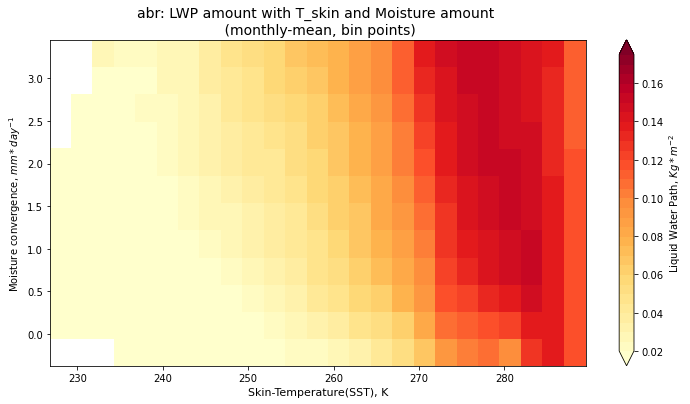

In [21]:
#plt.figure(figsize=(9,6))

#..y and x are SST and water vapor path at some points, Perspectively
#y, x = np.mgrid[slice(0., 80. + dy, dy), slice(240.,290.+ dx, dx)]
y = np.linspace(np.nanpercentile(p_e_mon_bin_abr, 5), np.nanpercentile(p_e_mon_bin_abr, 95), 13)
#print(y)
#print(np.linspace(np.nanpercentile(SST_predi, 5), np.nanpercentile(SST_predi, 96), 50))
x = np.linspace(np.nanpercentile(SST_mon_bin_abr, 5), np.nanpercentile(SST_mon_bin_abr, 95), 26)
#print(x.shape, y.shape)


LWP_bin_Tskew_wvp =  binned_skewTamnW(SST_mon_bin_abr, p_e_mon_bin_abr, LWP_mon_bin_abr, y, x)

print(LWP_bin_Tskew_wvp.shape)

anmean_LWP_bin_Tskew_wvp  = np.nanmean(LWP_bin_Tskew_wvp, axis=0)
print(anmean_LWP_bin_Tskew_wvp.shape)

ind_nan = np.isnan(anmean_LWP_bin_Tskew_wvp.flatten())==True
ind_flase =  np.array(np.nonzero(ind_nan==True))
print(ind_flase.shape)

#print(np.linspace(np.nanpercentile(SST_bin_pred_abr, 5), np.nanpercentile(SST_bin_pred_abr, 96), 50))
'''
LWP_pi = np.zeros((161, 51))
LWP_abr  = np.zeros((161,51))

for i in np.arange(161):
    for j in np.arange(57):
        
        if SST_predi >= (240.+j*1.0) and SST_predi < (240.+(j+1)*1.0) and PRW_predi > (0.+ 0.5*i) and PRW_predi < (0+ 0.5 *(i+1)) :
'''        

## begins for plotting Pcolormesh 

X, Y  = np.meshgrid(x, y)
#print(X.shape, Y.shape, anmean_LWP_bin_Tskew_wvp.shape)

#..defined a proper LWP ticks within its range

levels = np.arange(0.02, 0.18, 0.005)

#..pick the desired colormap
cmap = plt.get_cmap('YlOrRd')

norm = BoundaryNorm(levels, ncolors= cmap.N, extend='both')



#.. what will the pcolormesh plot looks like?
fig,ax  = plt.subplots(figsize =(12,6))

print(ax)

im  = ax.pcolormesh(x, y, anmean_LWP_bin_Tskew_wvp, cmap=cmap, norm= norm)
ax.set_title('abr: LWP amount with T_skin and Moisture amount \n (monthly-mean, bin points)', fontsize = 14)
ax.set_xlabel('Skin-Temperature(SST), K', fontsize=11)
#ax.set_ylabel('Water Vapor Path, ' + r'$Kg*m^{-2}$', fontsize=10)

ax.set_ylabel('Moisture convergence, ' + r'$mm*day^{-1}$')
fig.colorbar(im, ax= ax, label="Liquid Water Path, " + r"$Kg*m^{-2}}$")


#plt.savefig('pcolor-_ LWP_Tskew_ MC_ abr| monbin.png')


(25, 12)
(1, 0)
(13, 26) (13, 26) (12, 25)


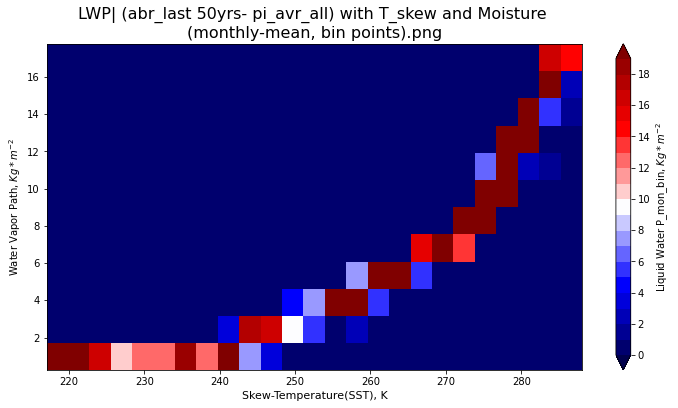

In [14]:
#plt.figure(figsize=(9,6))   #.. Try to use: LWP|abr_(last 50 years) - pi(99 yrs average) with Tskew\ Water Vapor Path

#.. Calculate the time average of WVP, LWP, skin_T and (p-e) over last 50 yrs in abrupt4xCO2 run:
PRW_abr_last50 =  np.nanmean(PRW_mon_bin_abr[-50:,:,:], axis=0)
LWP_abr_last50 =  np.nanmean(LWP_mon_bin_abr[-50:,:,:], axis=0)
SST_abr_last50 =  np.nanmean(SST_mon_bin_abr[-50:,:,:], axis=0)
p_e_abr_last50 =  np.nanmean(p_e_mon_bin_abr[-50:,:,:], axis=0)
#print(SST_abr_last50)


#.. Calculate the time-averaged data over the entire pi-Control period:
PRW_pi_aver   =   np.nanmean(PRW_mon_bin[:,:,:], axis=0)
LWP_pi_aver   =   np.nanmean(LWP_mon_bin[:,:,:], axis=0)
SST_pi_aver   =   np.nanmean(SST_mon_bin[:,:,:], axis=0)
p_e_pi_aver   =   np.nanmean(p_e_mon_bin[:,:,:], axis=0)
#print(PRW_pi_aver.shape)


#.. the difference between the abr_last50 and pi period
diff_LWP =  LWP_abr_last50 -LWP_pi_aver

#diff_SST =  SST_abr_last50 - SST_pi_aver
#diff_PRW =  PRW_abr_last50 - PRW_pi_aver

#..y and x are SST and Water vapor path at 5X5 bin points for monthly data, in pi-Control experiment, Perspectively
y = np.linspace(np.nanpercentile(PRW_pi_aver, 0), np.nanpercentile(PRW_pi_aver, 100), 13)

x = np.linspace(np.nanpercentile(SST_pi_aver, 0), np.nanpercentile(SST_pi_aver, 100), 26)

#print(np.linspace(np.nanpercentile(SST_predi, 5), np.nanpercentile(SST_predi, 96), 50))
#print(y)
#print(x.shape, y.shape)



#..2D array of LWP resampled over skin_T and WVP&(p-e) fields
LWP_bin_Tskin_wvp, xedge, yedge, binnumber  = stats.binned_statistic_2d(SST_pi_aver.ravel(), PRW_pi_aver.ravel(), values = diff_LWP.ravel(),
                                                                           statistic ='count', bins=[x, y], expand_binnumbers =True)
print(LWP_bin_Tskin_wvp.shape)
LWP_bin_Tskin_wvp  = LWP_bin_Tskin_wvp.T

ind_nan = np.isnan(LWP_bin_Tskin_wvp.flatten())==True
ind_flase =  np.array(np.nonzero(ind_nan==True))
print(ind_flase.shape)


## begins for plotting Pcolormesh


fig,ax  = plt.subplots(figsize =(12,6))

X, Y  = np.meshgrid(x, y)
print(X.shape, Y.shape, LWP_bin_Tskin_wvp.shape)

#..defined a proper LWP ticks within its range
#levels = np.arange(-0.050, 0.050, 0.0005)
levels = range(0, 20, 1)

#..pick the desired colormap
cmap = plt.get_cmap('seismic')
norm = BoundaryNorm(levels, ncolors= cmap.N, extend='both')


im  = ax.pcolormesh(x, y, LWP_bin_Tskin_wvp[:, :], cmap=cmap, norm = norm)

ax.set_title('LWP| (abr_last 50yrs- pi_avr_all) with T_skew and Moisture \n(monthly-mean, bin points).png', fontsize = 16)
ax.set_xlabel('Skew-Temperature(SST), K', fontsize=11)
ax.set_ylabel('Water Vapor Path, ' + r'$Kg*m^{-2}$', fontsize=10)

#ax.set_ylabel('Moisture convergence, ' + r'$mm*day^{-1}$')
fig.colorbar(im, ax= ax, label="Liquid Water P_mon_bin, " + r"$Kg*m^{-2}}$")


#plt.savefig('pcolor-_ LWP_abr(last50)-pi_ Tskew(pi)_ WVP(pi)_ monbin.png')
